# HSL: Data-analytiikka
# Ennakkotehtävä 16.02.2023

# Reitti:

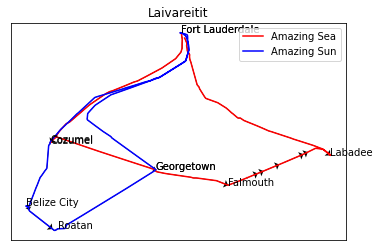

In [503]:
import matplotlib.pyplot as plt
import numpy as np
from pandas_ods_reader import read_ods
import pandas as pd
import utm

df_orig = read_ods("lu99397hpl0a.ods")
df = read_ods("lu99397hpl0a.ods")
df = df.dropna()

amazingseas = df[df["vessel"] == "Amazing Sea"]
amazingsuns = df[df["vessel"] == "Amazing Sun"]

(EASTINGSEA, NORTHINGSEA, __, __) = utm.from_latlon(amazingseas["latitude"].to_numpy(), 
                                                    amazingseas["longitude"].to_numpy())
(EASTINGSUN, NORTHINGSUN, __, __) = utm.from_latlon(amazingsuns["latitude"].to_numpy(), 
                                                    amazingsuns["longitude"].to_numpy())

# --- Laivareitit ---
plt.title("Laivareitit")

def arrowpath(plt,x,y,plotcolor):
  plt.plot(x,y,color=plotcolor)
  plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, headwidth=10)

arrowpath(plt, EASTINGSEA, NORTHINGSEA, 'r')
arrowpath(plt, EASTINGSUN, NORTHINGSUN, 'b')
plt.legend(['Amazing Sea', 'Amazing Sun'])

harborsmask = df["departure_port_name"].shift().to_numpy() != df["departure_port_name"].to_numpy()
(harbors_x, harbors_y, __, __) = utm.from_latlon(df[harborsmask]["latitude"].to_numpy(), 
                                                 df[harborsmask]["longitude"].to_numpy())

for i, name in enumerate(df["departure_port_name"][harborsmask].to_numpy()):
    plt.annotate(name, (harbors_x[i], harbors_y[i]))

plt.xticks([])  
plt.yticks([]);
# --- Laivareitit ---

# Nopeus vs teho:

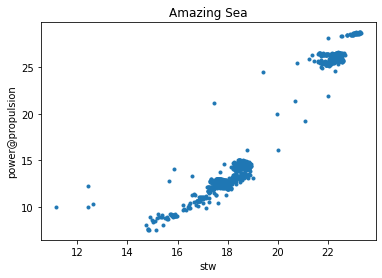

In [504]:
plt.title("Amazing Sea")
plt.plot(amazingseas["stw"], amazingseas["power@propulsion"], '.')
plt.xlabel("stw")
plt.ylabel("power@propulsion");

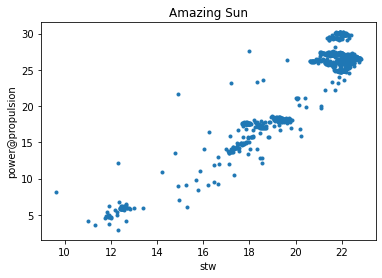

In [505]:
plt.title("Amazing Sun")
plt.plot(amazingsuns["stw"], amazingsuns["power@propulsion"], '.')
plt.xlabel("stw")
plt.ylabel("power@propulsion");

Huomataan, että yleisesti teho vaikuttaa lisääntyvän eksponentiaalisesti nopeuden suhteen.
Joskus myös samaan nopeuteen menee enemmän tehoa.
Reiteillä on hieman erilaiset profiilit.

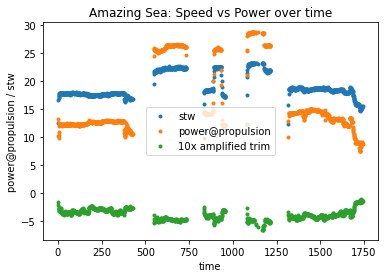

In [506]:
plt.title("Amazing Sea: Speed vs Power over time")
plt.plot(amazingseas["stw"], ".")
plt.plot(amazingseas["power@propulsion"], ".")
plt.plot(10*amazingseas["trim"], ".")
plt.xlabel("time")
plt.ylabel("power@propulsion / stw")
plt.legend(["stw", "power@propulsion", "10x amplified trim"]);

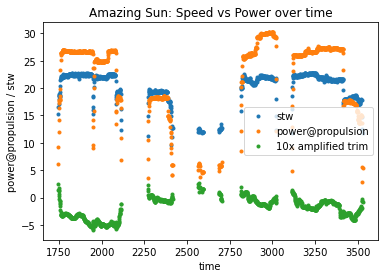

In [507]:
plt.title("Amazing Sun: Speed vs Power over time")
plt.plot(amazingsuns["stw"], ".")
plt.plot(amazingsuns["power@propulsion"], ".")
plt.plot(10*amazingsuns["trim"], ".")
plt.xlabel("time")
plt.ylabel("power@propulsion / stw")
plt.legend(["stw", "power@propulsion", "10x amplified trim"]);

Ploteista havaitaan, että nopeuden ja tehon suhde on vaihtunut myös reiteillä.
Kertooko tämä jotain reittien ominaisuuksista, esimerkiksi vaihtuneista lasteista?

Voimme myös kysyä, että miksi stw ei ole sama kaikilla reiteillä?

Koska muuttujien suhteet kuitenkin vaihtuvat, vaikka nopeus olisi välillä melkein sama, niin voimme päätellä, että laivoille voisi etsiä alinta tehoa, jolla saataisiin sama nopeus. Tämä laskisi polttoaineen kulutusta. Lisäksi trim heiluu, mikä voi johtua nopeuden vaihteluista tai vain meriolosuhteista.

Ehkä aineisto on kerätty erilaisilla nopeuksilla yms., jotta voitaisiin etsiä optimaaleja kaikille reiteille, eri nopeuksista yms.

# Trim:

Optimaalista trimiä on etsitty puolestamme jo muuttujaan optim. trim, joka on ainakin stw:n ja power@propulsion:n funktio, mutta luultavasti myös trim on huomioitu. Optim. trim on sellainen trim, jolla ajaa siten, että saadaan matalimmalla teholla tietty nopeus.

Katsotaan, miltä trimit näyttävät toistaiseksi aineistossa:



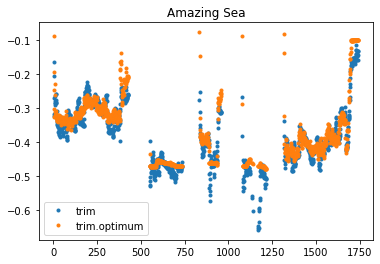

In [508]:
plt.title("Amazing Sea")
plt.plot(amazingseas["trim"], ".")
plt.plot(amazingseas["trim.optimum"], ".")
plt.legend(["trim", "trim.optimum"]);

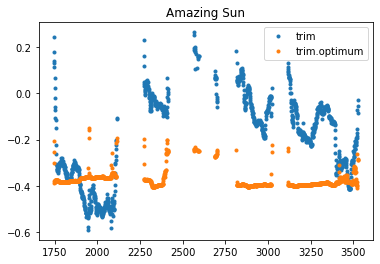

In [509]:
plt.title("Amazing Sun")
plt.plot(amazingsuns["trim"], ".")
plt.plot(amazingsuns["trim.optimum"], ".")
plt.legend(["trim", "trim.optimum"]);

Huomataan, että optimaalinen trim on ainakin tasaisempi.

Tutkitaan, heijastuuko nopeus trimiin:

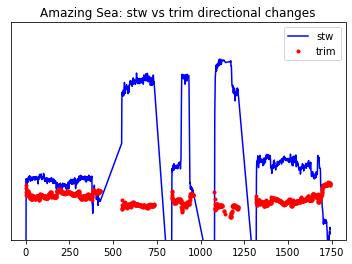

In [510]:
plt.title("Amazing Sea: stw vs trim directional changes")
plt.plot(amazingseas["stw"],'b')
plt.plot(np.mean(amazingseas["stw"])-1+3*amazingseas["trim"],'r.')
plt.ylim((15,25))
plt.legend(["stw", "trim"])
plt.yticks([]);

Eli ainakin Amazing Sean nopeus ja trim käyttäytyvät vastakkaisesti. Kun nopeus nousee, niin trim laskee. Koska trim:n lasku tarkoittaa sitä, että laivan keulaan kohdistuu enemmän veden vastusta, niin tämä ei ole ainakaan ideaali ilmiö, vaikka se onkin normaali, mikäli trim on negatiivinen. Mutta onko mahdollista, että laiva on lastattu liian keulapainotteisesti? Sama ilmiö näkyy Amazing Sunilla:

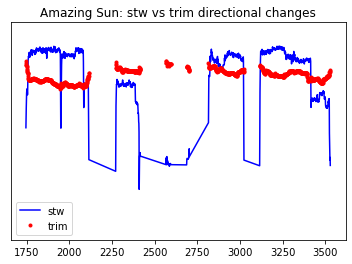

In [511]:
plt.title("Amazing Sun: stw vs trim directional changes")
plt.plot(amazingsuns["stw"],'b')
plt.plot(np.mean(amazingsuns["stw"])+3*amazingsuns["trim"],'r.')
plt.ylim((5,25))
plt.legend(["stw","trim"])
plt.yticks([]);

# Laivan asento satamissa ("static trim"):

Trimit satamissa:
[-0.3618898305084746, -0.24752083333333338, -0.30911111111111106, -0.31947422680412374, 0.014166666666666666, 0.10822580645161291, 0.023845454545454548, 0.04529069767441861]


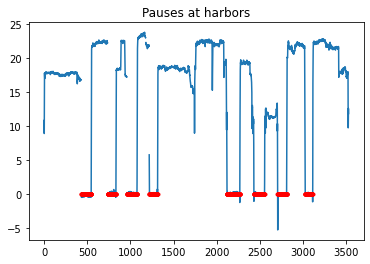

In [512]:
pauses = df_orig[df_orig["departure_port_name"].to_numpy() == None]

pidx = {'indices': pauses.index}
pausetimes = pd.DataFrame(data=pidx)

plt.title("Pauses at harbors")
plt.plot(df_orig["stw"])
plt.plot(pausetimes, np.zeros(pausetimes.size), "r.")

pauselist = []
pauselist.append(pausetimes["indices"][0])
for i, val in enumerate(pausetimes[:-1]["indices"], 1):
    if (pausetimes["indices"].loc[i] - pausetimes["indices"].loc[i-1]) > 1:
        pauselist.append(pausetimes["indices"].loc[i])
pauselist.append(max(pausetimes["indices"]))

reversepauselist = np.flip(pauselist)
pausedict = {}
for i in range(1,len(reversepauselist)):
    interval = pausetimes["indices"].between(reversepauselist[i], reversepauselist[i-1]-1)
    pausedict[len(reversepauselist)-i] = pausetimes[interval]["indices"]

pausetrims = []
for i in range(min(pausedict.keys()),max(pausedict.keys())+1):
    pausetrims.append(np.mean(df_orig.loc[pausedict[i]]["trim"]))

print("Trimit satamissa:")
print(pausetrims);

Huomataan yllä, että Amazing Sea:lla trim on satamassa ollessa -0.3:n tienoilla eli laivan nokassa on enemmän painoa.

Amazing Sun:lla taas trim on ~0 eli laiva on satamassa tasapainossa.

# Optimaalinen trim:

Katsotaan ensin kunkin laivan koko reittiä.

Löydämme suoraan optimaalisen trimin tietylle nopeudelle seuraavilla ploteilla:

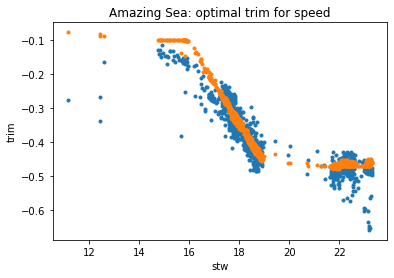

In [513]:
plt.title("Amazing Sea: optimal trim for speed")
plt.plot(amazingseas["stw"], amazingseas["trim"],'.')
plt.plot(amazingseas["stw"], amazingseas["trim.optimum"],'.')
plt.xlabel("stw")
plt.ylabel("trim");

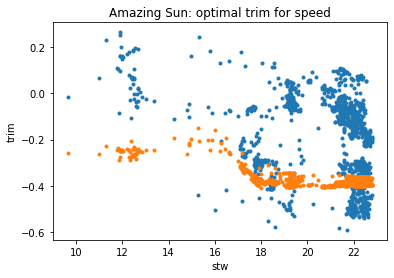

In [514]:
plt.title("Amazing Sun: optimal trim for speed")
plt.plot(amazingsuns["stw"], amazingsuns["trim"],'.')
plt.plot(amazingsuns["stw"], amazingsuns["trim.optimum"],'.')
plt.xlabel("stw")
plt.ylabel("trim");

Mutta huomaamme, että Amazing Sun:n data voisi olla epäsiistiä, koska samalle nopeudelle löytyy niin paljon erilaisia trimejä.

Tutkitaan, miten optimaalinen trim poikkeaa trim:stä:

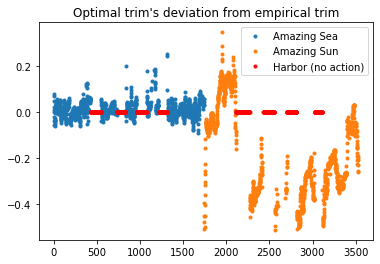

In [515]:
import pandas as pd
aseatrimdiffs = pd.DataFrame({'a': amazingseas["trim"],
                              'b': amazingseas["trim.optimum"]})
asuntrimdiffs = pd.DataFrame({'a': amazingsuns["trim"],
                              'b': amazingsuns["trim.optimum"]})
plt.title("Optimal trim's deviation from empirical trim")
plt.plot(aseatrimdiffs.diff(axis=1)["b"],'.')
plt.plot(asuntrimdiffs.diff(axis=1)["b"],'.')
plt.plot(pausetimes, np.zeros(pausetimes.size), "r.")
plt.legend(["Amazing Sea", "Amazing Sun", "Harbor (no action)"]);

Huomataan, että Amazing Sea:lla optimaalinen trim on kohtuullisen lähellä jo matkalla ollutta trimiä. Trimin kohtuullinen varianssi ei haittaa, koska ellei laivojen painolasteja voi tai osata muuttaa, niin varianssille ei voi kuitenkaan välttämättä tehdä mitään.

Sen sijaan Amazing Sun:lla optimaalinen trim olisi yleensä merkittävästi alempana kuin saavutettu trim ja lisäksi eri intervalleilla on eroja.

Siirrytään siksi tarkastelemaan yksittäisiä välejä:

In [516]:
cutoffs = []
for i in range(min(pausedict.keys()),max(pausedict.keys())+1):
    cutoffs.append(round(np.mean(df_orig.loc[pausedict[i]].index)))

sailings = df_orig[df_orig["departure_port_name"].to_numpy() != None]
sailingssea = sailings[sailings["vessel"] == "Amazing Sea"]
sailingssun = sailings[sailings["vessel"] == "Amazing Sun"]

sailingssealist = []
sailingssunlist = []

sailingssealist.append(sailingssea.loc[0:cutoffs[0]])
for i in range(1, 5):
    sailingssealist.append(sailingssea.loc[cutoffs[i-1]:cutoffs[i]])

for i in range(4, len(cutoffs)):
    sailingssunlist.append(sailingssun.loc[cutoffs[i-1]:cutoffs[i]])
sailingssunlist.append(sailingssun.loc[cutoffs[len(cutoffs)-1]:max(sailingssun.index)])

# "Dynamic trim":

Nyt voidaan analysoida jokaista väliä erikseen, jolloin jokaisesta välistä on myös mahdollista tuottaa yksilöllisiä analyysejä.

Palataan siksi aiempiin satamoiden trimmeihin.

[-0.3618898305084746, -0.24752083333333338, -0.30911111111111106, -0.31947422680412374, 0.014166666666666666, 0.10822580645161291, 0.023845454545454548, 0.04529069767441861]


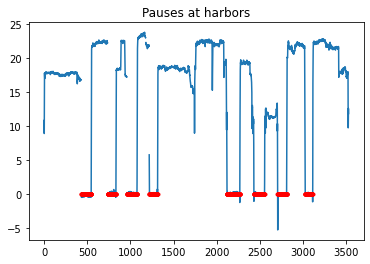

In [517]:
print(pausetrims)
plt.title("Pauses at harbors")
plt.plot(df_orig["stw"])
plt.plot(pausetimes, np.zeros(pausetimes.size), "r.");

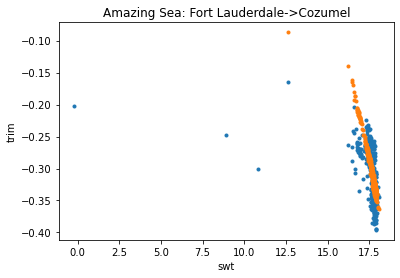

In [518]:
def piecewisestwtrim_sea(idx):
  plt.title("Amazing Sea: "+df["departure_port_name"][harborsmask].to_numpy()[idx]+"->"+
            df["departure_port_name"][harborsmask].to_numpy()[idx+1])
  plt.plot(sailingssealist[idx]["stw"],sailingssealist[idx]["trim"],'.')
  plt.plot(sailingssealist[idx]["stw"],sailingssealist[idx]["trim.optimum"],'.')
  if idx > 0:
    plt.axhline(pausetrims[idx-1]) # quick index fix, since the first route does not have harbor data.
  plt.xlabel("swt")
  plt.ylabel("trim")
piecewisestwtrim_sea(0)

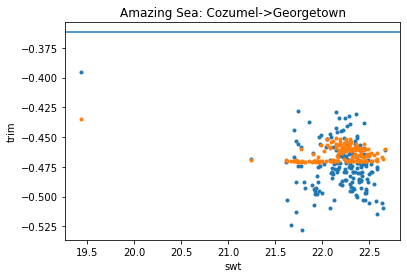

In [519]:
piecewisestwtrim_sea(1)

Hajonta ei ole kovin suuri tässä!

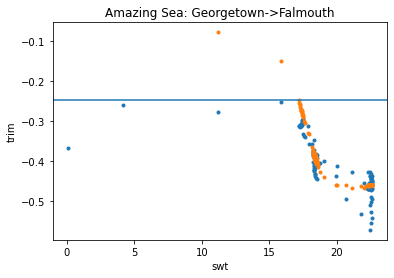

In [520]:
piecewisestwtrim_sea(2)

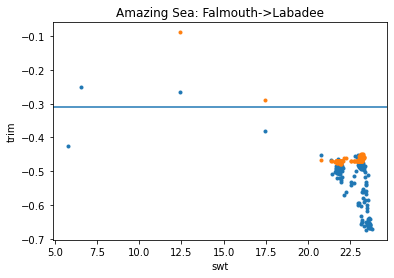

In [521]:
piecewisestwtrim_sea(3)

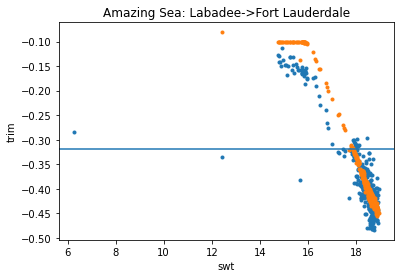

In [522]:
piecewisestwtrim_sea(4)

Näille viimeisille voisi varmaan miettiä jotain parannusta, mutta näissä voi myös olla jokin satunnainen meri-ilmiö (aallokkoa tms.), koska samalla nopeudella trim vaihtelee.

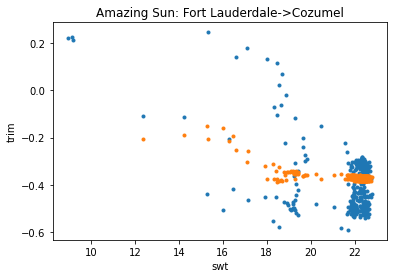

In [523]:
def piecewisestwtrim_sun(idx):
  plt.title("Amazing Sun: "+df["departure_port_name"][harborsmask].to_numpy()[5+idx]+"->"+
            df["departure_port_name"][harborsmask].to_numpy()[(5+idx+1) % 10])  
  plt.plot(sailingssunlist[idx]["stw"],sailingssunlist[idx]["trim"],'.')
  plt.plot(sailingssunlist[idx]["stw"],sailingssunlist[idx]["trim.optimum"],'.')
  if idx > 0:
    plt.axhline(pausetrims[4+idx-1]) # quick index fix, since the first route does not have harbor data.
  plt.xlabel("swt")
  plt.ylabel("trim")
piecewisestwtrim_sun(0)

Tämä näyttää hieman kohinaiselta datalta. Onko taas ollut aallokkoa?

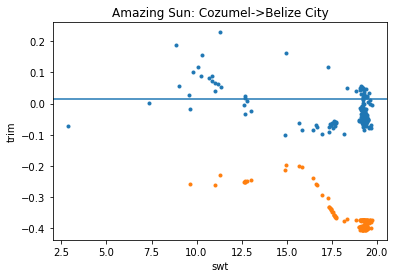

In [524]:
piecewisestwtrim_sun(1)

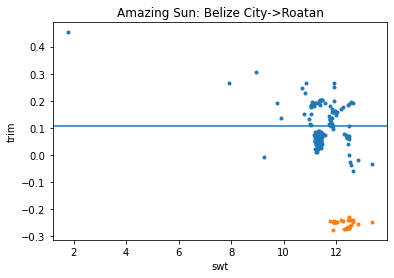

In [525]:
piecewisestwtrim_sun(2)

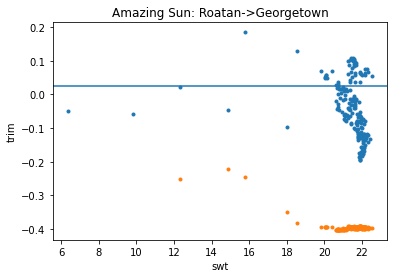

In [526]:
piecewisestwtrim_sun(3)

Näissä kolmessa viimeisessä nokka näyttää osoittavan reilusti ylemmäs kuin mitä optimaalinen trim vaatisi.
Tämä voisi suosittaa, että paino on liian takana, ja lastausta olisi pitänyt painottaa enemmän eteen.

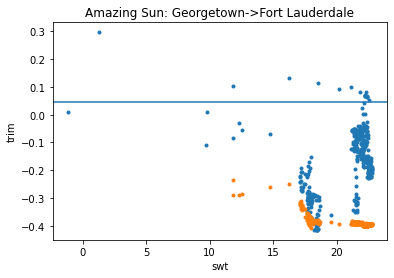

In [527]:
piecewisestwtrim_sun(4)

Mutta tässäkin on aikalailla nokka pystyssä suhteessa optimiin.